In [2]:
#load path
import os
import sys
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip

from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from astropy.visualization import (ImageNormalize, MinMaxInterval,PercentileInterval,SqrtStretch)
import glob
from astropy.time import Time




In [3]:
path='./data/'
rawpath=r'/Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/'
calibpath='./data/Calibs/'
reduxpath='./data/Redux/'
gain=0.25 #e-/ADU at G = 125

In [4]:
def dateobs_to_mjd(dateobs):
    """
    Convert a DATE-OBS string (or astropy-parsable time) to MJD (float).
    """
    t = Time(dateobs, scale='utc')   # astropy auto-parses common formats
    return float(t.mjd)


In [5]:
#Read all the reduced files and plot the fluxcal values over time
#Divide per different filters

instrfailures = ['2025-09-28_20-02-32']

fluxcalfiles = glob.glob(reduxpath+'*reduced.fits')
fluxcalfiles.sort()
fluxcaltimes = {'R':[], 'G':[], 'I':[], 'Ha':[], 'Hb':[], 'OIII':[], 'SII':[]}
fluxcalvalues = {'R':[], 'G':[], 'I':[], 'Ha':[], 'Hb':[], 'OIII':[], 'SII':[]}
fwhmvalues = []
psfaxrvalues = []
psftimes = []

alltimes = []

extinction = {'R':0.06, 'G':0.16, 'I':0.02, 'Ha':0.06, 'Hb':0.16, 'OIII':0.16, 'SII':0.06}

for file in fluxcalfiles:
    if any(fail in file for fail in instrfailures):
        print('Skipping file due to known instrument failure:', file)
        continue
    hdu = fits.open(file)
    try:
        fluxcal = hdu[0].header['ABZP']
        timeobs = dateobs_to_mjd(hdu[0].header['DATE-OBS'])-0.5
        nstars = hdu[0].header['FCALSTR']
        filter = hdu[0].header['FILTER']
        airmass = hdu[0].header['AIRMASS']-1
        fwhm = hdu[0].header['PSFFWHM']*0.55
        axrat = hdu[0].header['PSFAXRAT']
        fluxcal -= airmass*extinction[filter]
        if nstars>10:
          fluxcaltimes[filter].append(timeobs)
          fluxcalvalues[filter].append(fluxcal)
          fwhmvalues.append(fwhm)
          psfaxrvalues.append(axrat)
          psftimes.append(timeobs)
          alltimes.append(timeobs)
        #print('File:', os.path.basename(file), 'Time: {:8.4f} ZP: {:6.2f}'.format(timeobs,fluxcal))
    except KeyError:
        print('No FLUXCAL in', file)

unique_nights = np.unique(np.floor(np.array(alltimes)))
Nnights = len(unique_nights)

Skipping file due to known instrument failure: ./data/Redux/2025-09-28_20-02-32_sci_BD25_Ha_exp120.00_0000_reduced.fits


2


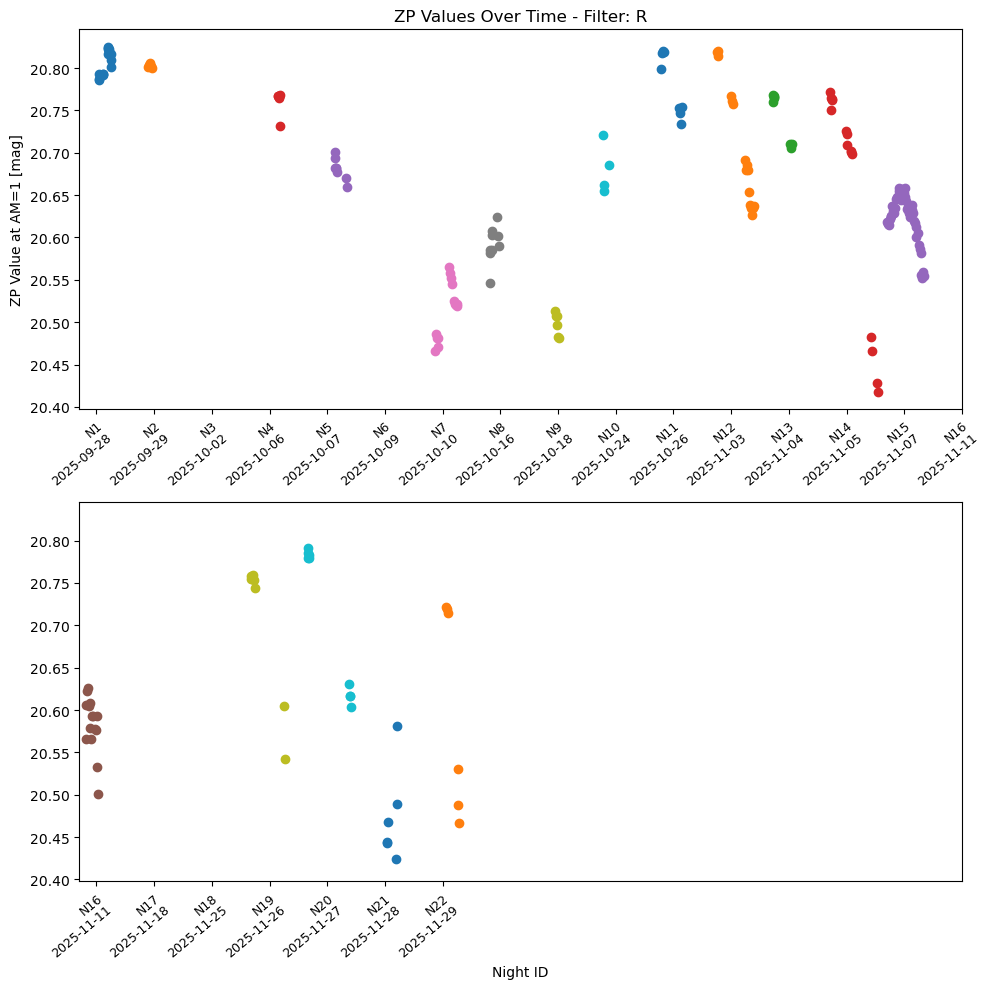

2


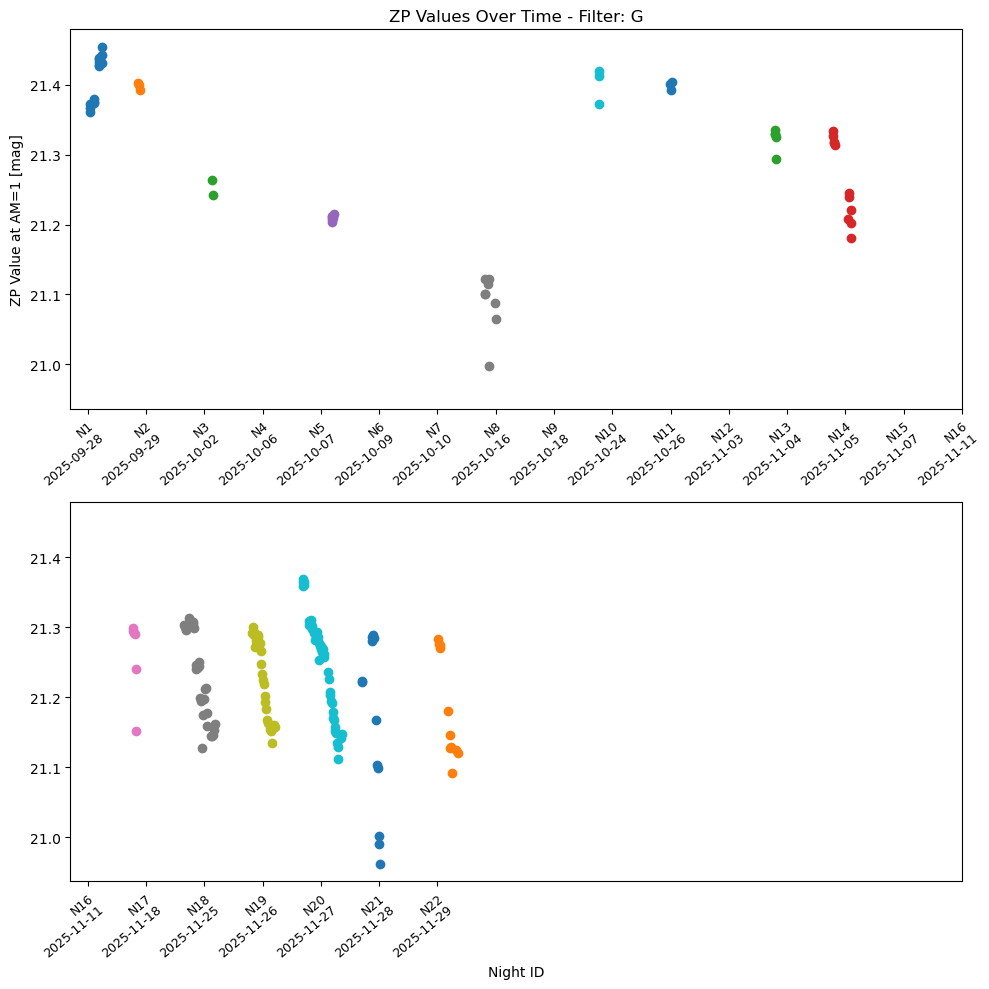

2


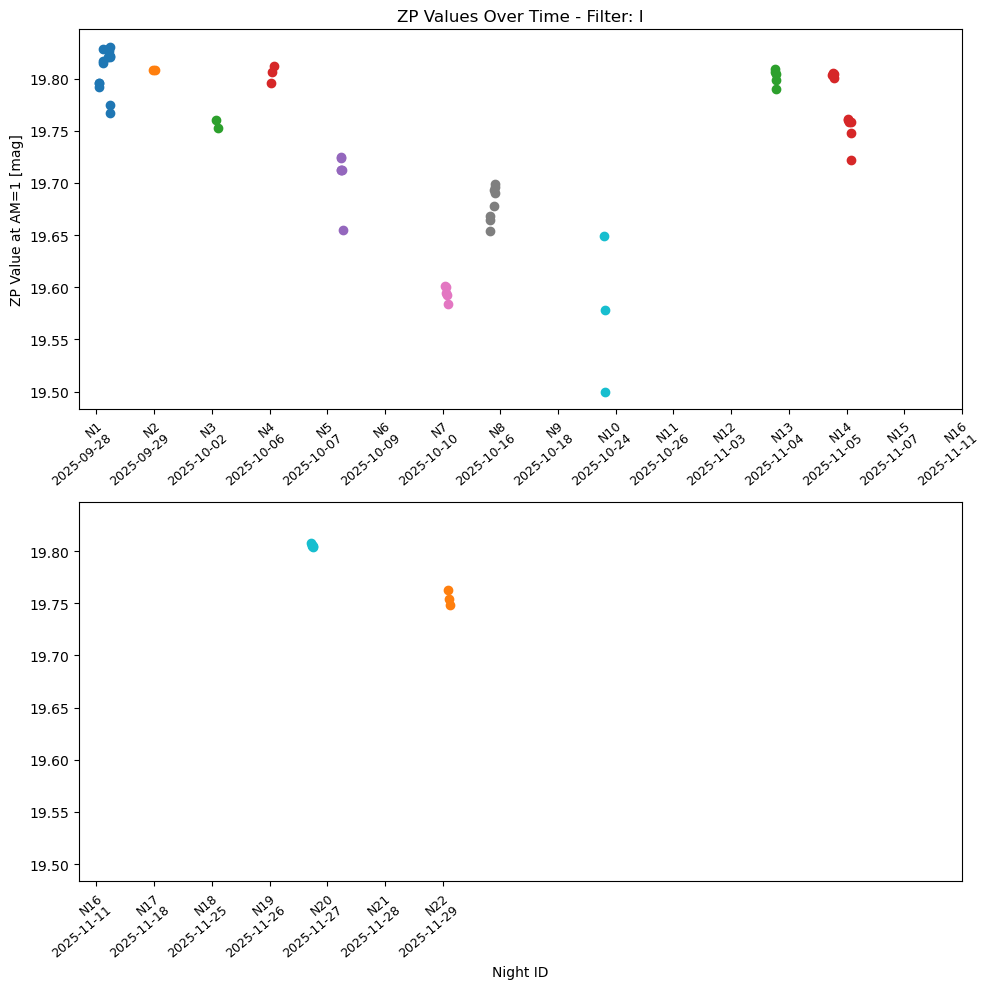

2


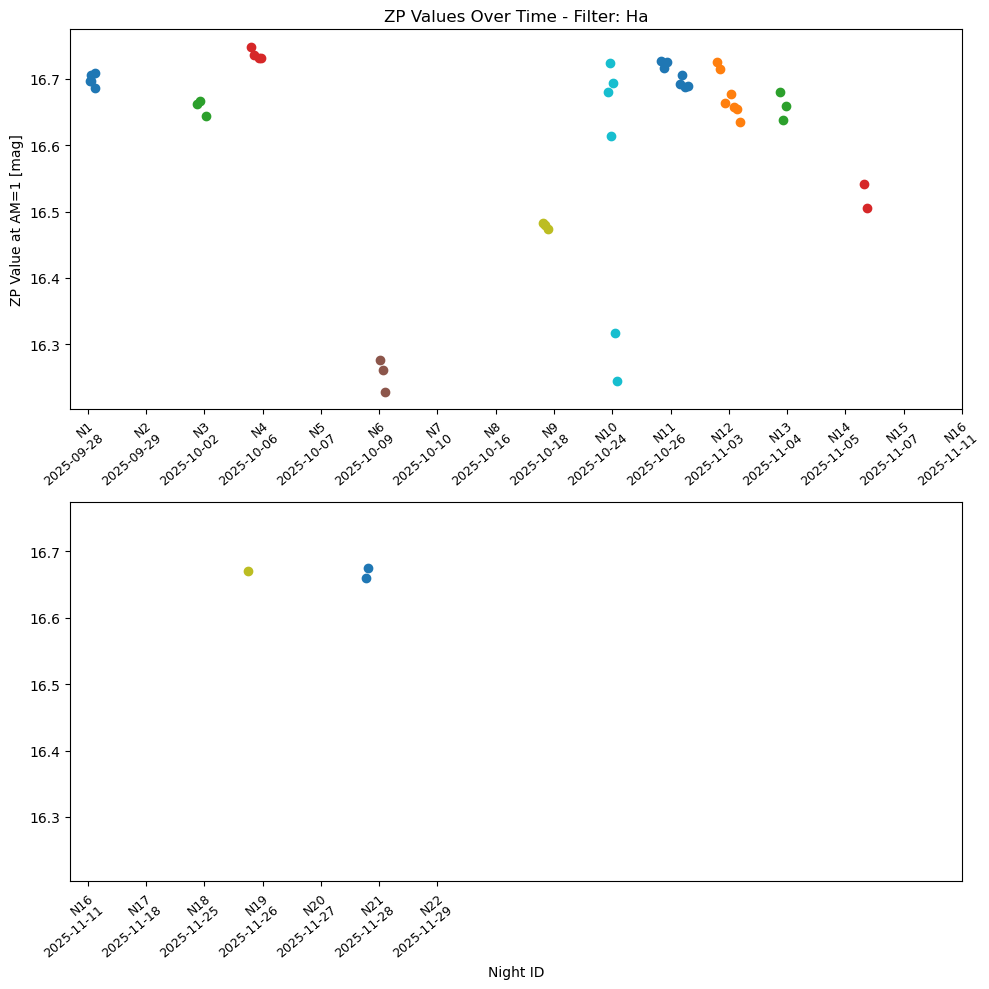

2


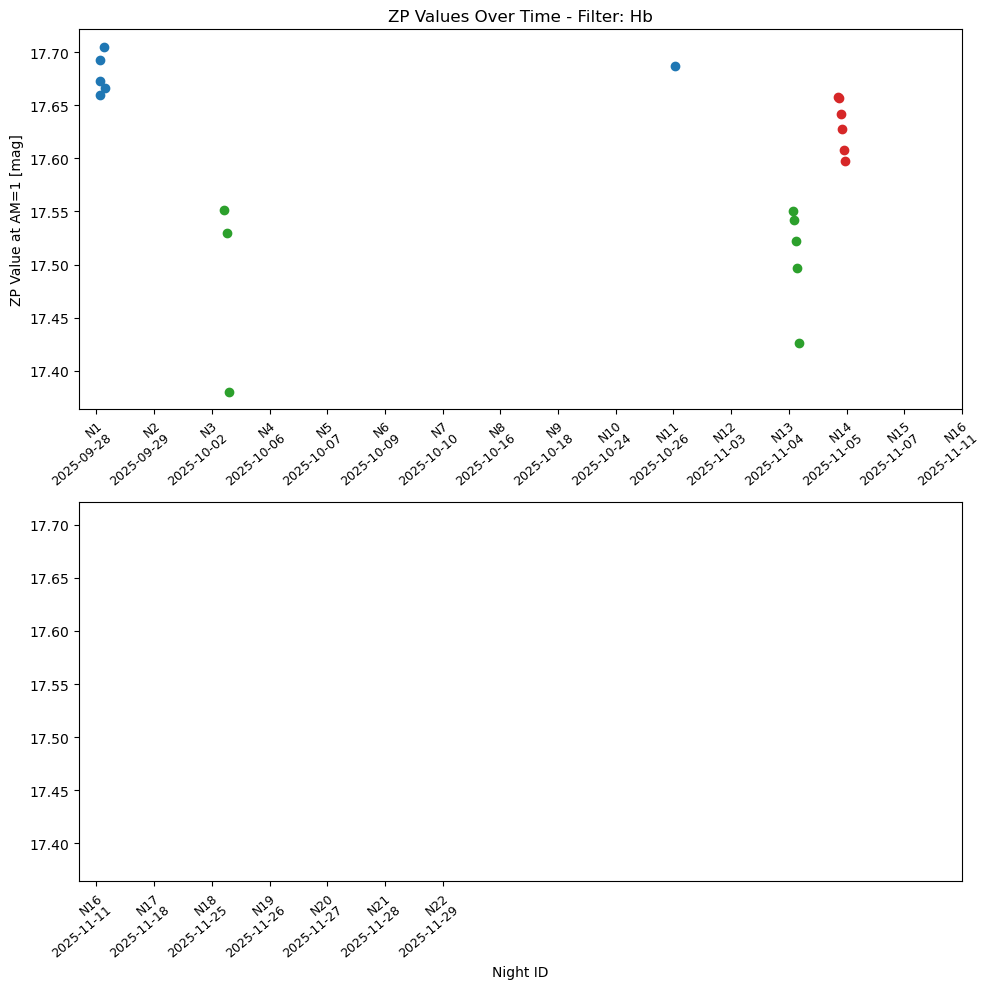

2


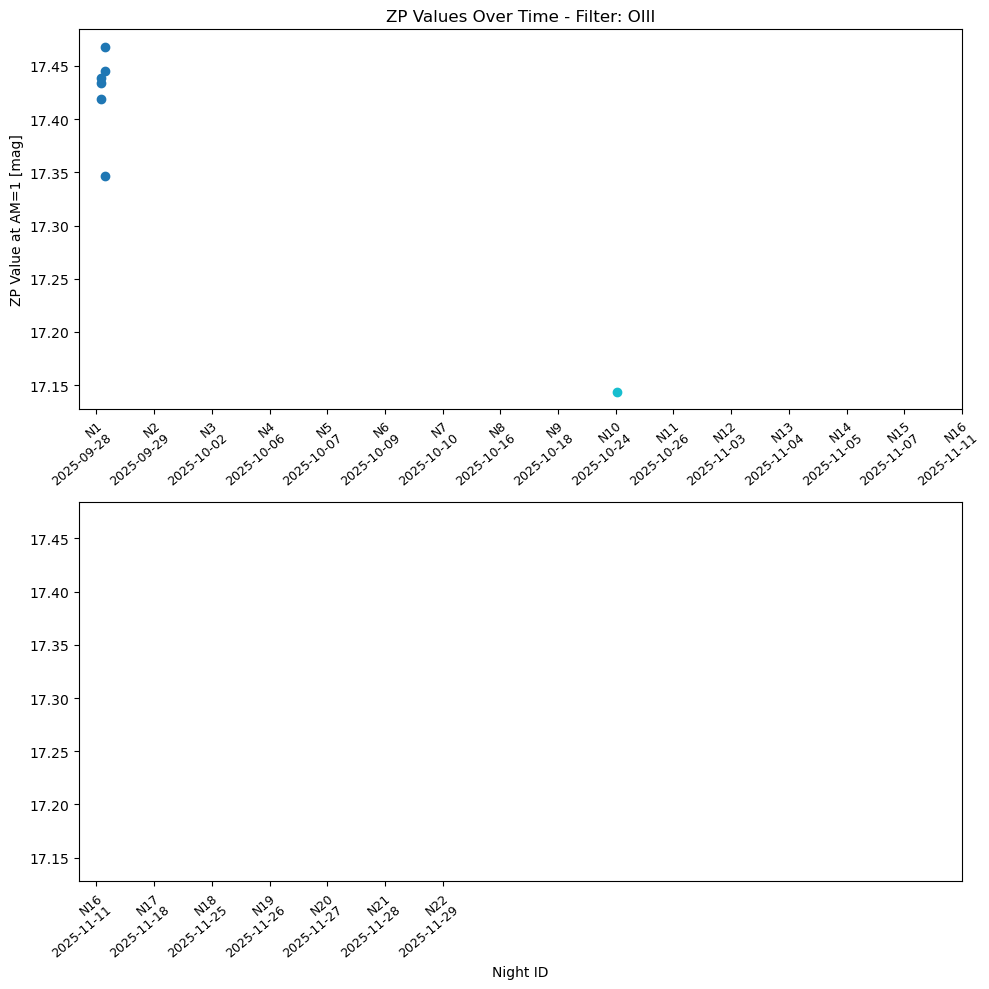

2


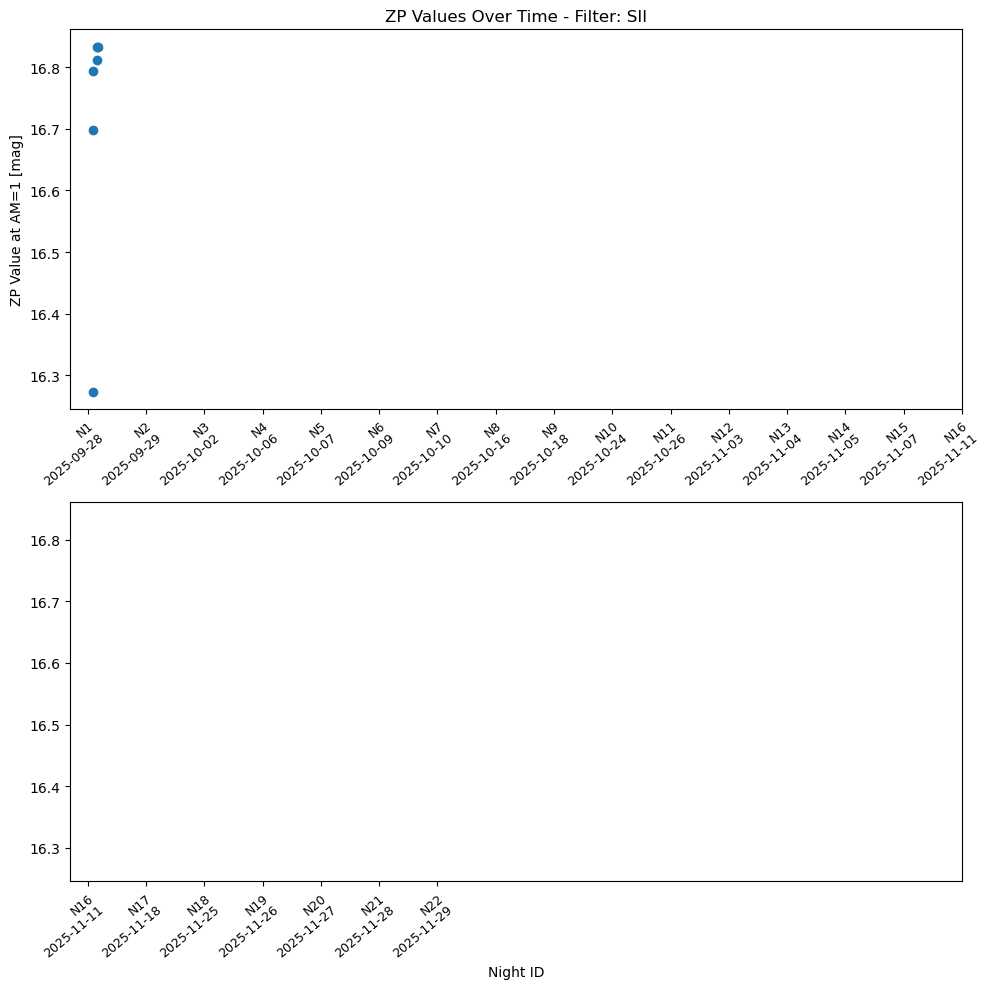

In [7]:
#plot fluxcalvalues over time for each filter
Nights_per_plot = 15
for filter in fluxcalvalues.keys():
    if len(fluxcalvalues[filter])>0:
        nrows = Nnights // Nights_per_plot + 1
        print(nrows)
        fig, ax = plt.subplots(ncols=1, nrows=2, sharey=True, figsize=(10,5*nrows))
        fig.subplots_adjust(hspace=0.3)
        night = 0
        xticks = []
        xticklabels = []
        #derive integer part of mjd to group by day and plot different colors for different nights
        intmjd = np.floor(np.array(fluxcaltimes[filter]))
        for nn in unique_nights:
            night_indices = np.where(intmjd == nn)[0]
            timearr = np.array(fluxcaltimes[filter])
            valarr = np.array(fluxcalvalues[filter])
            #Define x axis values, 0 is midday, 1 is next midday, trim away space between 0.3 and 0.6 and stretch the rest (should be changed if we observe beyond 1st half night
            xaxis = (((timearr[night_indices]-nn)-0.3)/(1-0.7))+night
            ax[night//Nights_per_plot].plot(xaxis, valarr[night_indices], 'o', color='C{}'.format(night%10), label=f'N{night+1} MJD={int(nn)}')
            xticks.append(night)
            xticklabels.append('N{}\n{}'.format(night+1,Time(nn, format='mjd').iso[:10] ))
            night += 1

        for axs in range(nrows):
         ax[axs].set_xticks(xticks)
         ax[axs].set_xticklabels(xticklabels, rotation=40, fontsize=9, rotation_mode='anchor', ha='right')
         ax[axs].set_xlim(-0.3+Nights_per_plot*axs,Nights_per_plot*(axs+1))
        ax[-1].set_xlabel('Night ID')
        ax[0].set_ylabel('ZP Value at AM=1 [mag]')
        ax[0].set_title(f'ZP Values Over Time - Filter: {filter}')
        fig.tight_layout()
        plt.show()




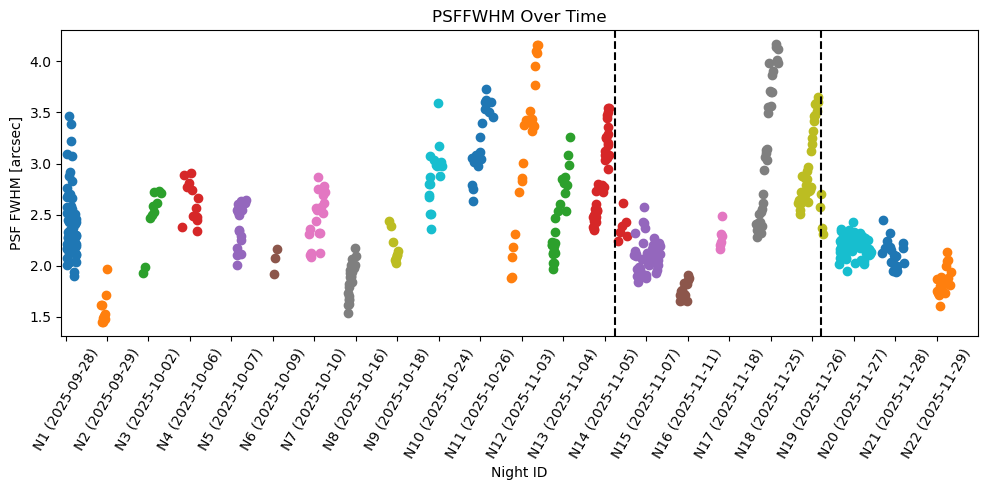

In [73]:
plt.figure(figsize=(10,5))
night = 0
xticks = []
xticklabels = []
#derive integer part of mjd to group by day and plot different colors for different nights
intmjd = np.floor(np.array(psftimes))
for nn in unique_nights:
    night_indices = np.where(intmjd == nn)[0]
    timearr = np.array(psftimes)
    valarr = np.array(fwhmvalues)
    #Define x axis values, 0 is midday, 1 is next midday, trim away space between 0.3 and 0.6 and stretch the rest (should be changed if we observe beyond 1st half night
    xaxis = (((timearr[night_indices]-nn)-0.3)/(1-0.7))+night
    plt.plot(xaxis, valarr[night_indices], 'o', color='C{}'.format(night%10), label=f'N{night+1} MJD={int(nn)}')
    xticks.append(night)
    xticklabels.append('N{} ({})'.format(night+1,Time(nn, format='mjd').iso[:10] ))
    night += 1

plt.axvline(13.25, color='black', linestyle='--', label='Refocus')
plt.axvline(18.22, color='black', linestyle='--', label='Refocus')
plt.xticks(xticks, xticklabels)
plt.xticks(rotation=60)
plt.xlabel('Night ID')
plt.ylabel('PSF FWHM [arcsec]')
plt.xlim(-0.1,night)
plt.title(f'PSFFWHM Over Time')
plt.tight_layout()
plt.show()


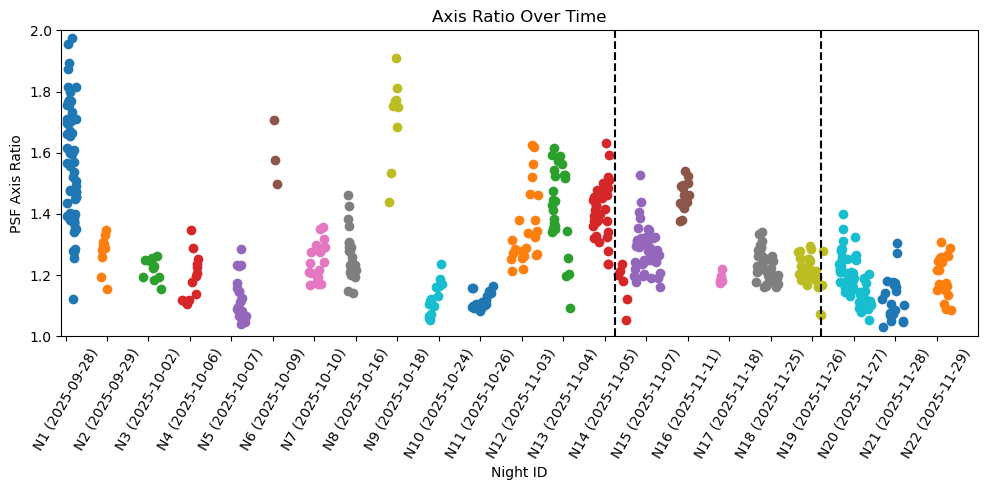

In [74]:
plt.figure(figsize=(10,5))
night = 0
xticks = []
xticklabels = []
#derive integer part of mjd to group by day and plot different colors for different nights
intmjd = np.floor(np.array(psftimes))
for nn in unique_nights:
    night_indices = np.where(intmjd == nn)[0]
    timearr = np.array(psftimes)
    valarr = np.array(psfaxrvalues)
    #Define x axis values, 0 is midday, 1 is next midday, trim away space between 0.3 and 0.6 and stretch the rest (should be changed if we observe beyond 1st half night
    xaxis = (((timearr[night_indices]-nn)-0.3)/(1-0.7))+night
    plt.plot(xaxis, valarr[night_indices], 'o', color='C{}'.format(night%10), label=f'N{night+1} MJD={int(nn)}')
    xticks.append(night)
    xticklabels.append('N{} ({})'.format(night+1,Time(nn, format='mjd').iso[:10] ))
    night += 1

plt.axvline(13.25, color='black', linestyle='--', label='Refocus')
plt.axvline(18.22, color='black', linestyle='--', label='Refocus')
plt.xticks(xticks, xticklabels)
plt.xticks(rotation=60)
plt.xlabel('Night ID')
plt.ylabel('PSF Axis Ratio')
plt.xlim(-0.1,night)
plt.ylim(1,2)
plt.title(f'Axis Ratio Over Time')
plt.tight_layout()
plt.show()